In [1]:
import pandas as pd

df = pd.read_csv('/Users/mustakahmad/Library/CloudStorage/OneDrive-purdue.edu/FACAI LAB/Project3_tariff/tariff_war/raw_data/2025_jun30_tariffwar.csv')  # replace with your file path
df = df.dropna()

In [2]:
import pandas as pd

# Ensure data is sorted
df = df.sort_values("Year").reset_index(drop=True)

# Create lag features
df['forest_loss_t-1'] = df['natural_forest_loss (h)'].shift(1)
df['forest_loss_t-2'] = df['natural_forest_loss (h)'].shift(2)

# Drop missing values from lags
df = df.dropna().reset_index(drop=True)

# Define features
features = ['forest_loss_t-1', 'forest_loss_t-2',
            'Hurs', 'pr', 'tas', 'soy_production(ton)', 'Soybean_production(h)']

In [3]:
# Training: 2002–2015
train_mask = df['Year'] <= 2015
X_train = df.loc[train_mask, features]
y_train = df.loc[train_mask, 'natural_forest_loss (h)']

# Evaluation: 2016–2018
eval_mask = (df['Year'] >= 2016) & (df['Year'] <= 2018)
X_eval = df.loc[eval_mask, features]
y_eval = df.loc[eval_mask, 'natural_forest_loss (h)']

# Impact Analysis: 2019–2024
impact_mask = df['Year'] >= 2019
X_impact = df.loc[impact_mask, features]
y_impact = df.loc[impact_mask, 'natural_forest_loss (h)']

In [4]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Train model
model_rf = RandomForestRegressor(n_estimators=1000, random_state=42)
model_rf.fit(X_train, y_train)

# Predict for evaluation set (2016–2018)
y_pred_eval = model_rf.predict(X_eval)

# RMSE
rmse_eval = np.sqrt(mean_squared_error(y_eval, y_pred_eval))
print("Random Forest RMSE (2016–2018):", rmse_eval)

# R-squared
r2 = r2_score(y_eval, y_pred_eval)
print("Random Forest R² (2016–2018):", r2)

Random Forest RMSE (2016–2018): 1695838.3153446803
Random Forest R² (2016–2018): -5.318948828140336


In [5]:
# Predict counterfactual baseline
y_pred_impact = model_rf.predict(X_impact)

# Combine for comparison
impact_years = df.loc[impact_mask, 'Year']
impact_df = pd.DataFrame({
    'Year': impact_years.values,
    'Actual_Forest_Loss': y_impact.values,
    'Predicted_Counterfactual': y_pred_impact
})

# Optional: Add difference or percent change
impact_df['Difference'] = impact_df['Actual_Forest_Loss'] - impact_df['Predicted_Counterfactual']
impact_df['%_Change'] = (impact_df['Difference'] / impact_df['Predicted_Counterfactual']) * 100

print(impact_df)

   Year  Actual_Forest_Loss  Predicted_Counterfactual    Difference  \
0  2019        1.512562e+06             841964.047094  6.705976e+05   
1  2020        2.412874e+06             851665.651404  1.561209e+06   
2  2021        2.937789e+06             863309.876627  2.074479e+06   
3  2022        3.430619e+06             864209.167770  2.566410e+06   
4  2023        3.070628e+06             907311.939015  2.163316e+06   

     %_Change  
0   79.646826  
1  183.312387  
2  240.293688  
3  296.966304  
4  238.431339  


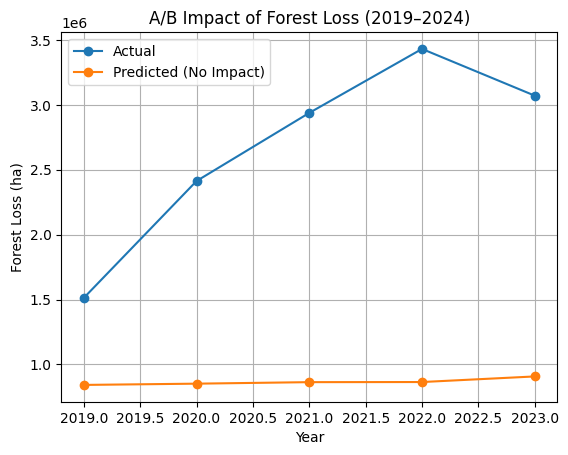

In [6]:
import matplotlib.pyplot as plt

plt.plot(impact_df['Year'], impact_df['Actual_Forest_Loss'], label='Actual', marker='o')
plt.plot(impact_df['Year'], impact_df['Predicted_Counterfactual'], label='Predicted (No Impact)', marker='o')
plt.title("A/B Impact of Forest Loss (2019–2024)")
plt.ylabel("Forest Loss (ha)")
plt.xlabel("Year")
plt.legend()
plt.grid(True)
plt.show()

✅ Evaluation Results (2016–2018)
RMSE: 1698132.22
R²: -5.3361


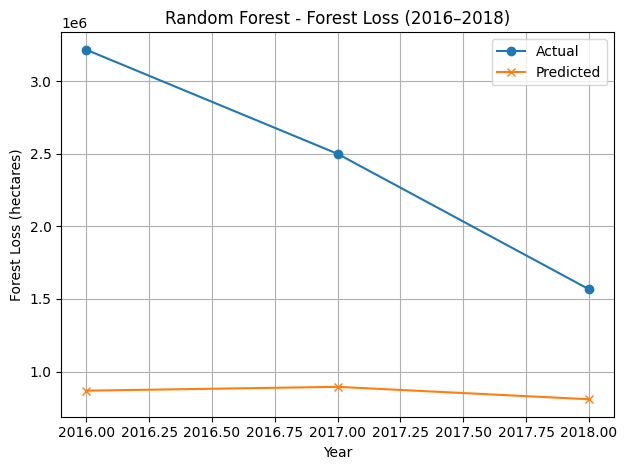

In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# -------------------------
# Step 1: Prepare the data
# -------------------------

# Sort by year
df = df.sort_values("Year").reset_index(drop=True)

# Apply log transformation to target
df['log_forest_loss'] = np.log1p(df['natural_forest_loss (h)'])

# Create lag features for the target
df['log_loss_t-1'] = df['log_forest_loss'].shift(1)
df['log_loss_t-2'] = df['log_forest_loss'].shift(2)

# (Optional) Create lag features for exogenous variables
# You can uncomment these if needed
# for var in ['Hurs', 'pr', 'tas', 'soy_production(ton)', 'Soybean_production(h)']:
#     df[f'{var}_t-1'] = df[var].shift(1)

# Drop rows with NaN (due to lagging)
df = df.dropna().reset_index(drop=True)

# -------------------------
# Step 2: Define features and target
# -------------------------

features = ['log_loss_t-1', 'log_loss_t-2', 'Hurs', 'pr', 'tas',
            'soy_production(ton)', 'Soybean_production(h)']

target = 'log_forest_loss'

# -------------------------
# Step 3: Train-Test Split
# -------------------------

train_mask = df['Year'] <= 2015
eval_mask = (df['Year'] >= 2016) & (df['Year'] <= 2018)

X_train = df.loc[train_mask, features]
y_train = df.loc[train_mask, target]

X_eval = df.loc[eval_mask, features]
y_eval = df.loc[eval_mask, target]  # still in log space

# -------------------------
# Step 4: Train Random Forest
# -------------------------

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Predict on evaluation set
y_pred_eval_log = model_rf.predict(X_eval)

# Inverse log transform to get back to original scale
y_pred_eval = np.expm1(y_pred_eval_log)
y_eval_actual = np.expm1(y_eval)

# -------------------------
# Step 5: Evaluate Performance
# -------------------------

rmse_eval = np.sqrt(mean_squared_error(y_eval_actual, y_pred_eval))
r2 = r2_score(y_eval_actual, y_pred_eval)

print("✅ Evaluation Results (2016–2018)")
print(f"RMSE: {rmse_eval:.2f}")
print(f"R²: {r2:.4f}")

# -------------------------
# Step 6: Plot Actual vs Predicted
# -------------------------

years_eval = df.loc[eval_mask, 'Year']

plt.plot(years_eval, y_eval_actual.values, label='Actual', marker='o')
plt.plot(years_eval, y_pred_eval, label='Predicted', marker='x')
plt.title("Random Forest - Forest Loss (2016–2018)")
plt.xlabel("Year")
plt.ylabel("Forest Loss (hectares)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

✅ Random Forest Evaluation (2015–2017):
RMSE: 1694688.31
R²: -5.3104

📊 A/B Impact Analysis (2018–2024) — Random Forest w/ Lags:
   Year  Actual_Forest_Loss  Predicted_Counterfactual    Difference  \
0  2019        1.512562e+06             830872.019325  6.816897e+05   
1  2020        2.412874e+06             839285.236562  1.573589e+06   
2  2021        2.937789e+06             841671.585064  2.096117e+06   
3  2022        3.430619e+06             845766.297434  2.584853e+06   
4  2023        3.070628e+06             901169.186472  2.169459e+06   

     %_Change  
0   82.045087  
1  187.491568  
2  249.042200  
3  305.622593  
4  240.738231  


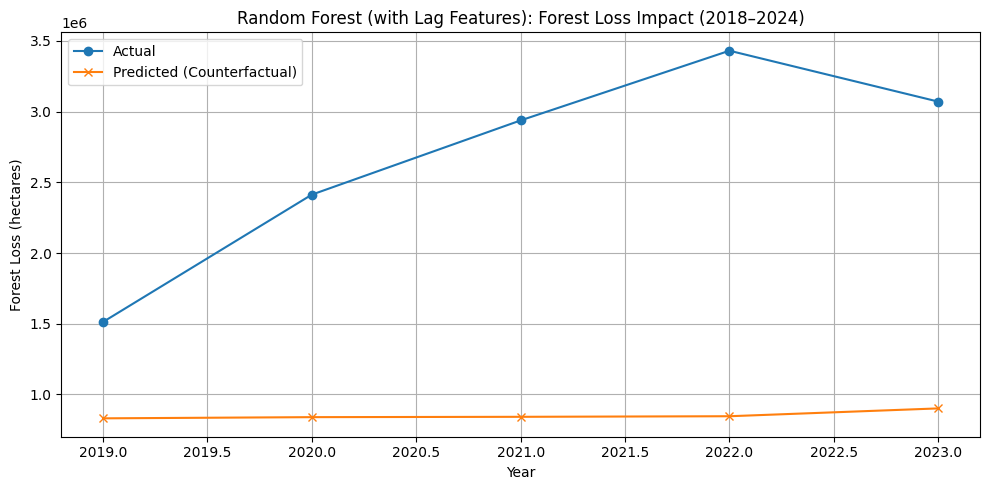

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# -------------------------------
# Step 1: Prepare the data
# -------------------------------

# Sort by year
df = df.sort_values("Year").reset_index(drop=True)

# Log-transform target
df['log_forest_loss'] = np.log1p(df['natural_forest_loss (h)'])

# Create lag features of the target
df['lag_1'] = df['log_forest_loss'].shift(1)
df['lag_2'] = df['log_forest_loss'].shift(2)

# Define base exogenous variables
exog_vars = ['Hurs', 'pr', 'tas', 'soy_production(ton)', 'Soybean_production(h)']
lag_vars = ['lag_1', 'lag_2']
features = exog_vars + lag_vars

# Drop rows with missing lag values
df = df.dropna(subset=features + ['log_forest_loss']).reset_index(drop=True)

# -------------------------------
# Step 2: Train-Test Split
# -------------------------------

train_mask = df['Year'] <= 2015
eval_mask = (df['Year'] >= 2016) & (df['Year'] <= 2018)
impact_mask = df['Year'] >= 2019

X_train = df.loc[train_mask, features]
y_train = df.loc[train_mask, 'log_forest_loss']

X_eval = df.loc[eval_mask, features]
y_eval = df.loc[eval_mask, 'log_forest_loss']

X_impact = df.loc[impact_mask, features]
y_impact = df.loc[impact_mask, 'log_forest_loss']
years_impact = df.loc[impact_mask, 'Year']

# -------------------------------
# Step 3: Fit Random Forest Model
# -------------------------------

model_rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
model_rf.fit(X_train, y_train)

# -------------------------------
# Step 4: Predict on Evaluation Set (2015–2017)
# -------------------------------

y_pred_eval_log = model_rf.predict(X_eval)
y_pred_eval = np.expm1(y_pred_eval_log)
y_eval_actual = np.expm1(y_eval)

# Metrics
rmse_eval = np.sqrt(mean_squared_error(y_eval_actual, y_pred_eval))
r2_eval = r2_score(y_eval_actual, y_pred_eval)

print("✅ Random Forest Evaluation (2015–2017):")
print(f"RMSE: {rmse_eval:.2f}")
print(f"R²: {r2_eval:.4f}")

# -------------------------------
# Step 5: Forecast 2018–2024 (Counterfactual)
# -------------------------------

y_pred_impact_log = model_rf.predict(X_impact)
y_pred_impact = np.expm1(y_pred_impact_log)
y_impact_actual = np.expm1(y_impact)

# Combine for impact analysis
impact_df_rf = pd.DataFrame({
    'Year': years_impact.values,
    'Actual_Forest_Loss': y_impact_actual.values,
    'Predicted_Counterfactual': y_pred_impact
})
impact_df_rf['Difference'] = impact_df_rf['Actual_Forest_Loss'] - impact_df_rf['Predicted_Counterfactual']
impact_df_rf['%_Change'] = (impact_df_rf['Difference'] / impact_df_rf['Predicted_Counterfactual']) * 100

print("\n📊 A/B Impact Analysis (2018–2024) — Random Forest w/ Lags:")
print(impact_df_rf)

# -------------------------------
# Step 6: Visualize Impact
# -------------------------------

plt.figure(figsize=(10, 5))
plt.plot(impact_df_rf['Year'], impact_df_rf['Actual_Forest_Loss'], label='Actual', marker='o')
plt.plot(impact_df_rf['Year'], impact_df_rf['Predicted_Counterfactual'], label='Predicted (Counterfactual)', marker='x')
plt.title("Random Forest (with Lag Features): Forest Loss Impact (2018–2024)")
plt.xlabel("Year")
plt.ylabel("Forest Loss (hectares)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()